<a href="https://colab.research.google.com/github/IGPTsewwandi/Image-Processing-Based-Smart-Waste-Management-System-/blob/feature%2Fpreprocess/Smart_Waste_Management_System_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Step 1: Setup and Load Dataset**

In [ ]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
from PIL import Image

# Mount Drive
drive.mount('/content/drive')

# dataset path
dataset_path = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Original"

# Load all images with class folders
classes = os.listdir(dataset_path)
print("Classes found:", classes)

image_files = []
labels = []

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        for f in os.listdir(cls_path):
            if f.lower().endswith(('.jpg','.jpeg','.png')):
                image_files.append(os.path.join(cls_path, f))
                labels.append(cls)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes found: ['import os.py', 'Metal', 'Plastic', 'Paper', 'Glass', 'Organic']


## **Step 2: Check Image Quality**

We’ll check blur and brightness for a few random images.

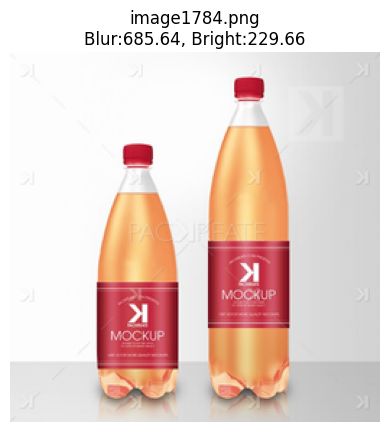

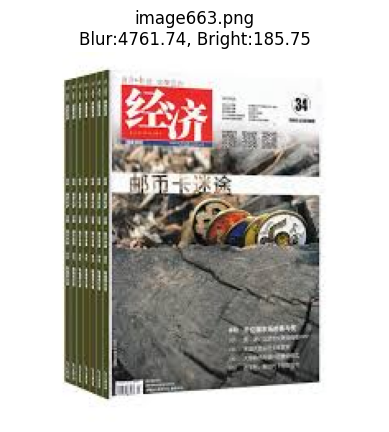

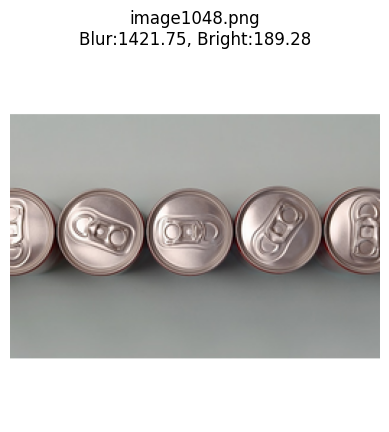

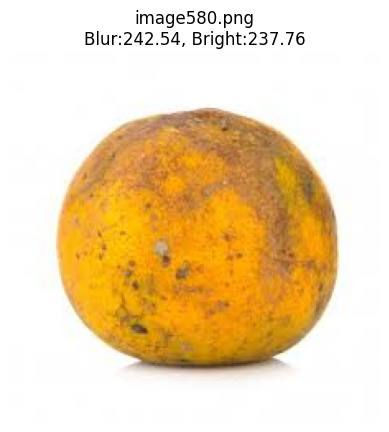

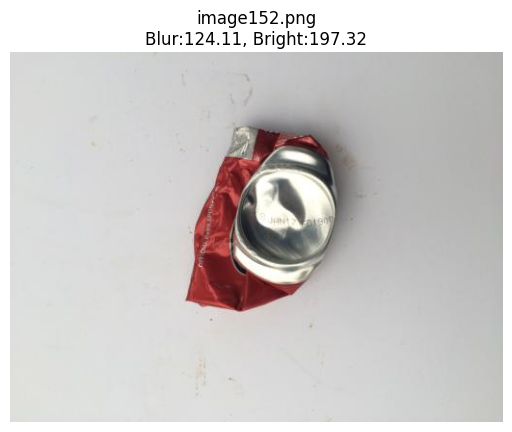

In [ ]:
def variance_of_laplacian(image):
    """Measure blur level using Laplacian variance."""
    return cv2.Laplacian(image, cv2.CV_64F).var()

def brightness(image):
    """Measure average brightness."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return np.mean(hsv[:,:,2])

# Pick random images and check quality
for i in range(5):
    path = random.choice(image_files)
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur_score = variance_of_laplacian(gray)
    bright_score = brightness(img)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{os.path.basename(path)}\nBlur:{blur_score:.2f}, Bright:{bright_score:.2f}")
    plt.axis("off")
    plt.show()


### **Step 3: Spot Missing / Duplicate / Corrupted Images**

In [ ]:
import os
from PIL import Image
import hashlib
import shutil

# Input dataset (original with possible duplicates)
dataset_path = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Original"
output_path = "/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE"

os.makedirs(output_path, exist_ok=True)

# Collect all image file paths
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

print("Total images found:", len(image_files))

# Step 1: Check corrupted images
corrupted = []
for path in image_files:
    try:
        img = Image.open(path)
        img.verify()
    except Exception:
        corrupted.append(path)

print("Corrupted images:", len(corrupted))

# Remove corrupted from list (do not copy them)
image_files = [f for f in image_files if f not in corrupted]

# Step 2: Check duplicates by file hash
hashes = {}
duplicates = []
for path in image_files:
    with open(path, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()
    if filehash in hashes:
        duplicates.append(path)
    else:
        hashes[filehash] = path

print("Duplicate images found:", len(duplicates))

# Final cleaned dataset = all images - corrupted - duplicates
cleaned_files = [f for f in image_files if f not in duplicates]
print("Cleaned dataset size:", len(cleaned_files))

# Step 3: Save cleaned dataset into new folder (preserve class structure)
for src_path in cleaned_files:
    rel_path = os.path.relpath(src_path, dataset_path)  # relative path from original root
    dst_path = os.path.join(output_path, rel_path)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy2(src_path, dst_path)  # copy file with metadata

print(f"✅ Cleaned dataset saved to: {output_path}")

Total images found: 10550
Corrupted images: 0
Duplicate images found: 156
Cleaned dataset size: 10394
✅ Cleaned dataset saved to: /content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE


### **Step 4: Dataset Distribution (per class)/ Data Visualization**

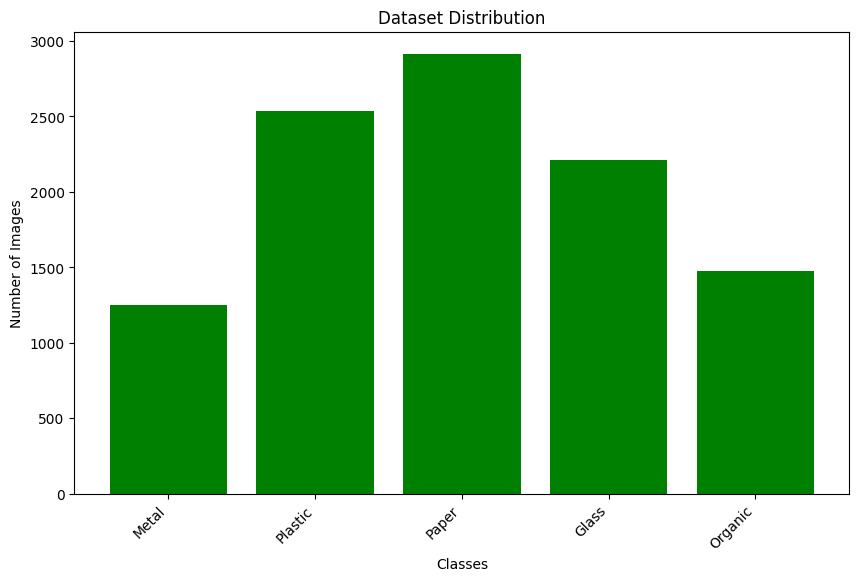

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Dataset path
dataset_path = "/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE"

# Count images in each class folder
dist = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        dist[class_name] = len([
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ])

# Plot
plt.figure(figsize=(10,6))
plt.bar(dist.keys(), dist.values(), color='green')
plt.title("Dataset Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.show()



In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Dataset path
dataset_path = "/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE"

# Collect all image paths from dataset
image_files = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for f in os.listdir(class_dir):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_files.append(os.path.join(class_dir, f))

def variance_of_laplacian(image):
    """Measure blur level using Laplacian variance."""
    return cv2.Laplacian(image, cv2.CV_64F).var()

def brightness(image):
    """Measure average brightness in HSV color space."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return np.mean(hsv[:,:,2])

def dataset_quality_summary(image_files):
    blur_scores = []
    bright_scores = []

    blurry, sharp = 0, 0
    dark, normal, bright_img = 0, 0, 0

    for path in tqdm(image_files, desc="Checking images"):
        try:
            img = cv2.imread(path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Blur check
            blur_val = variance_of_laplacian(gray)
            blur_scores.append(blur_val)
            if blur_val < 100:   # threshold for blur (tune if needed)
                blurry += 1
            else:
                sharp += 1

            # Brightness check
            bright_val = brightness(img)
            bright_scores.append(bright_val)
            if bright_val < 50:
                dark += 1
            elif bright_val > 200:
                bright_img += 1
            else:
                normal += 1

        except Exception as e:
            print(f"Error reading {path}: {e}")
            continue

    print("\n===== Dataset Quality Summary =====")
    print(f"Total Images: {len(image_files)}")
    print(f"Sharp Images: {sharp}")
    print(f"Blurry Images: {blurry}")
    print(f"Dark Images: {dark}")
    print(f"Normal Lighting Images: {normal}")
    print(f"Bright Images: {bright_img}")

    return blur_scores, bright_scores

# Run the check
blur_scores, bright_scores = dataset_quality_summary(image_files)



Checking images: 100%|██████████| 10394/10394 [02:27<00:00, 70.62it/s]


===== Dataset Quality Summary =====
Total Images: 10394
Sharp Images: 9504
Blurry Images: 890
Dark Images: 20
Normal Lighting Images: 6143
Bright Images: 4231


In [ ]:
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Dataset path
dataset_path = "/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE"


# Collect classes (only folders, ignore hidden files)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes found:", classes)

image_files = []
labels = []

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(imgs) == 0:
        print(f"⚠️ No images found in {cls}, skipping...")
        continue

    for f in imgs:
        image_files.append(os.path.join(cls_path, f))
        labels.append(cls)

print(f"✅ Total images collected: {len(image_files)}")
print(f"✅ Class distribution: {Counter(labels)}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes found: ['Metal', 'Plastic', 'Paper', 'Glass', 'Organic']
✅ Total images collected: 10394
✅ Class distribution: Counter({'Paper': 2917, 'Plastic': 2537, 'Glass': 2213, 'Organic': 1476, 'Metal': 1251})


## **Check image quality → blur / brightness / orientation.**


Step 1: Check Image Quality
Blur, brightness, orientation
Flag low-quality images


In [ ]:
import cv2
import os
from collections import Counter
from PIL import Image

dataset_path = "/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE"

# Classes
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    total = len(imgs)
    blurry = 0
    dark = 0
    bright = 0
    corrupted = 0

    for f in imgs:
        path = os.path.join(cls_path, f)
        try:
            img = cv2.imread(path)
            if img is None:
                corrupted += 1
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Blur detection
            fm = cv2.Laplacian(gray, cv2.CV_64F).var()
            if fm < 100:  # threshold
                blurry += 1

            # Brightness check
            mean_val = gray.mean()
            if mean_val < 50:
                dark += 1
            elif mean_val > 200:
                bright += 1

        except Exception:
            corrupted += 1

    low_quality = blurry + dark + bright + corrupted

    print(f"\nClass '{cls}':")
    print(f"  Total images: {total}")
    print(f"  Blurry: {blurry}")
    print(f"  Dark: {dark}, Bright: {bright}")
    print(f"  Corrupted: {corrupted}")
    print(f"  Low-quality images flagged: {low_quality}")



Class 'Metal':
  Total images: 1251
  Blurry: 83
  Dark: 1, Bright: 401
  Corrupted: 0
  Low-quality images flagged: 485

Class 'Plastic':
  Total images: 2537
  Blurry: 226
  Dark: 9, Bright: 864
  Corrupted: 0
  Low-quality images flagged: 1099

Class 'Paper':
  Total images: 2917
  Blurry: 318
  Dark: 4, Bright: 619
  Corrupted: 0
  Low-quality images flagged: 941

Class 'Glass':
  Total images: 2213
  Blurry: 249
  Dark: 10, Bright: 922
  Corrupted: 0
  Low-quality images flagged: 1181

Class 'Organic':
  Total images: 1476
  Blurry: 14
  Dark: 9, Bright: 262
  Corrupted: 0
  Low-quality images flagged: 285


# **Image Enhancement**
Sharpen blurry images
Adjust contrast/brightness
Optional histogram equalization


Keeps original images untouched.

Enhances only low-quality images (blurry, dark, bright).

Saves all images (enhanced + normal) in dataset_enhanced folder.

Maintains the same class-wise folder structure.


In [ ]:
import cv2
import numpy as np
from glob import glob
import os

# Dataset directory (original) and target enhanced directory
train_dir = "/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE"
enhanced_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Enhanced"
os.makedirs(enhanced_dir, exist_ok=True)

# find class folders
classes = [c for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))]
print("Classes to process:", classes)

# Thresholds
BLUR_THRESHOLD = 100
BRIGHT_DARK_THRESHOLD = 50

# Function to check image quality
def check_image_quality(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, True, None, "corrupted", None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_value = cv2.Laplacian(gray, cv2.CV_64F).var()
    is_blurry = blur_value < BLUR_THRESHOLD

    mean_brightness = np.mean(gray)
    if mean_brightness < BRIGHT_DARK_THRESHOLD:
        brightness_status = "dark"
    elif mean_brightness > 200:
        brightness_status = "bright"
    else:
        brightness_status = "normal"

    height, width = img.shape[:2]
    orientation = "portrait" if height > width else "landscape"

    return blur_value, is_blurry, mean_brightness, brightness_status, orientation

# Function to enhance images
def enhance_image(img, is_blurry, brightness_status):
    # Sharpen if blurry
    if is_blurry:
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        img = cv2.filter2D(img, -1, kernel)

    # Adjust brightness/contrast
    if brightness_status in ["dark", "bright"]:
        alpha = 1.2 if brightness_status == "dark" else 0.8
        beta = 20 if brightness_status == "dark" else -20
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Histogram equalization on Y channel
    try:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    except Exception:
        # in case conversion fails, just return current img
        pass

    return img

# Supported extensions (lowercase)
exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")

total_found = 0
total_saved = 0
total_skipped = 0

for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    # gather files with multiple extensions
    img_files = []
    for e in exts:
        img_files.extend(glob(os.path.join(cls_path, e)))
    img_files = sorted(list(set(img_files)))  # unique and sorted

    found = len(img_files)
    total_found += found

    print(f"\nClass '{cls}': found {found} image files.")
    if found > 0:
        print(" First 5 files:", img_files[:5])

    # ensure enhanced class folder exists
    enhanced_cls_path = os.path.join(enhanced_dir, cls)
    os.makedirs(enhanced_cls_path, exist_ok=True)

    saved = 0
    skipped = 0

    for img_file in img_files:
        # check quality
        blur_value, is_blurry, mean_brightness, brightness_status, orientation = check_image_quality(img_file)

        if brightness_status == "corrupted":
            skipped += 1
            continue

        img = cv2.imread(img_file)
        if img is None:
            skipped += 1
            continue

        # enhance image (you can choose to only enhance low-quality ones; here we enhance if any issue)
        if is_blurry or brightness_status in ["dark", "bright"]:
            enhanced_img = enhance_image(img, is_blurry, brightness_status)
        else:
            # you may still want to apply histogram equalization/resizing; here we keep normal images as-is
            enhanced_img = img

        filename = os.path.basename(img_file)
        save_path = os.path.join(enhanced_cls_path, filename)

        ok = cv2.imwrite(save_path, enhanced_img)
        if ok:
            saved += 1
        else:
            skipped += 1

    total_saved += saved
    total_skipped += skipped
    print(f" Class '{cls}' -> saved: {saved}, skipped: {skipped}")

print("\nSummary:")
print(" Total files found :", total_found)
print(" Total files saved  :", total_saved)
print(" Total files skipped:", total_skipped)
print("Enhanced images are in:", enhanced_dir)
print("done")


Classes to process: ['Metal', 'Plastic', 'Paper', 'Glass', 'Organic']

Class 'Metal': found 1251 image files.
 First 5 files: ['/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Metal/image1.png', '/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Metal/image10.png', '/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Metal/image100.png', '/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Metal/image1000.png', '/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Metal/image1001.png']
 Class 'Metal' -> saved: 1251, skipped: 0

Class 'Plastic': found 2537 image files.
 First 5 files: ['/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Plastic/image1.jpg', '/content/drive/MyDrive/Smart Waste Management System/DATASET_REMOVED_DUPLICATE/Plastic/image10.jpg', '/content/drive/MyDrive/Smart Waste Management System/DATASET_REM

# **Noise Reduction / Filtering**
Apply median filter, Gaussian filter, or denoising methods


In [ ]:
import cv2
import numpy as np
from glob import glob
import os

# Original dataset directory (already enhanced)
dataset_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Enhanced"

# New filtered dataset directory
filtered_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Filtered"
os.makedirs(filtered_dir, exist_ok=True)

classes = [c for c in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, c))]

# Function to apply noise reduction
def denoise_image(img, method="median"):
    """
    method: choose "median", "gaussian", or "nlmeans"
    """
    if method == "median":
        # Median filter (ksize=3)
        denoised = cv2.medianBlur(img, 3)
    elif method == "gaussian":
        # Gaussian blur (3x3 kernel)
        denoised = cv2.GaussianBlur(img, (3, 3), 0)
    elif method == "nlmeans":
        # Non-local means denoising
        denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    else:
        denoised = img  # no change
    return denoised

# Loop through all classes and images
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    save_cls_path = os.path.join(filtered_dir, cls)
    os.makedirs(save_cls_path, exist_ok=True)

    # Get all images of different types
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend(glob(os.path.join(cls_path, ext)))

    for img_file in img_files:
        img = cv2.imread(img_file)
        if img is None:
            continue

        # Apply denoising
        denoised_img = denoise_image(img, method="median")  # choose "median", "gaussian", or "nlmeans"

        # Save denoised image in the filtered dataset folder
        cv2.imwrite(os.path.join(save_cls_path, os.path.basename(img_file)), denoised_img)

    print(f"Class '{cls}' denoised and saved in filtered dataset.")

print("✅ All images denoised and saved in 'Dataset_Filtered'.")



Class 'Metal' denoised and saved in filtered dataset.
Class 'Plastic' denoised and saved in filtered dataset.
Class 'Paper' denoised and saved in filtered dataset.
Class 'Glass' denoised and saved in filtered dataset.
Class 'Organic' denoised and saved in filtered dataset.
✅ All images denoised and saved in 'Dataset_Filtered'.


# **Edge Detection & Morphological Processing**
Detect edges of waste objects
Morphology to clean edges (dilate, erode, fill holes)

Detects edges using Canny.

Cleans edges using dilation, erosion, and closing.


In [ ]:
import cv2
import numpy as np
from glob import glob
import os

# Dataset directory (already filtered)
dataset_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Filtered"

# New directory for edge-detected images
edge_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_EdgeDetected"
os.makedirs(edge_dir, exist_ok=True)

classes = [c for c in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, c))]

# Morphological kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Loop through all classes and images
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    save_cls_path = os.path.join(edge_dir, cls)
    os.makedirs(save_cls_path, exist_ok=True)

    # Get all images of different types
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend(glob(os.path.join(cls_path, ext)))

    for img_file in img_files:
        img = cv2.imread(img_file)
        if img is None:
            continue

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Edge detection (Canny)
        edges = cv2.Canny(gray, threshold1=100, threshold2=200)

        # Morphological operations
        edges = cv2.dilate(edges, kernel, iterations=1)
        edges = cv2.erode(edges, kernel, iterations=1)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        # Convert edges to 3-channel image to save as colored jpg
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # Save in the new edge dataset folder
        cv2.imwrite(os.path.join(save_cls_path, os.path.basename(img_file)), edges_colored)

    print(f"Class '{cls}' edges detected and saved in edge dataset.")

print("✅ Edge detection & morphological processing completed in 'Dataset_EdgeDetected'.")



Class 'Metal' edges detected and saved in edge dataset.
Class 'Plastic' edges detected and saved in edge dataset.
Class 'Paper' edges detected and saved in edge dataset.
Class 'Glass' edges detected and saved in edge dataset.
Class 'Organic' edges detected and saved in edge dataset.
✅ Edge detection & morphological processing completed in 'Dataset_EdgeDetected'.


# **Image Segmentation**
Segment object from background
Optional: Background subtraction, thresholding, or contour-based segmentation

Convert the processed image to grayscale (if not already).

Apply binary thresholding to segment the object.

Use contours to find the largest object (assuming it's the main waste object).

Mask the object and remove background.


In [ ]:
# @title
import cv2
import numpy as np
from glob import glob
import os

# Dataset directory (after edge & morphological processing)
dataset_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Enhanced"

classes = [c for c in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, c))]

# Loop through all classes and images
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
     # Get all images of different types
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend(glob(os.path.join(cls_path, ext)))

    for img_file in img_files:
        img = cv2.imread(img_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Thresholding to create binary image
        _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            continue  # skip if no object detected

        # Find largest contour (assume main object)
        largest_contour = max(contours, key=cv2.contourArea)

        # Create mask for the object
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

        # Apply mask to original image
        segmented = cv2.bitwise_and(img, img, mask=mask)

        # Optional: set background to white
        background = np.ones_like(img, dtype=np.uint8) * 255
        mask_inv = cv2.bitwise_not(mask)
        background_masked = cv2.bitwise_and(background, background, mask=mask_inv)
        final_segmented = cv2.add(segmented, background_masked)

        # Save the segmented image in-place
        cv2.imwrite(img_file, final_segmented)

    print(f"Class '{cls}' segmented and saved.")

print("Image segmentation done in-place.")


# **Resize & Standardization**
Resize all images to fixed size (e.g., 128×128, 224×224)
Convert to RGB if needed


In [ ]:
import cv2
import os
from glob import glob

# Dataset directory (edge-detected)
dataset_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_EdgeDetected"

# New directory for resized dataset
resized_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Resized"
os.makedirs(resized_dir, exist_ok=True)

# Desired image size
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Get classes
classes = [c for c in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, c))]

# Loop through all classes and images
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    save_cls_path = os.path.join(resized_dir, cls)
    os.makedirs(save_cls_path, exist_ok=True)

    # Get all images of different types
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend(glob(os.path.join(cls_path, ext)))

    for img_file in img_files:
        img = cv2.imread(img_file)
        if img is None:
            continue

        # Convert to RGB if grayscale
        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Resize image
        resized_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        # Save in the resized dataset folder
        cv2.imwrite(os.path.join(save_cls_path, os.path.basename(img_file)), resized_img)

    print(f"Class '{cls}' resized and saved in Dataset_Resized.")

print("✅ All images resized and converted to RGB in 'Dataset_Resized'.")



Class 'Metal' resized and saved in Dataset_Resized.
Class 'Plastic' resized and saved in Dataset_Resized.
Class 'Paper' resized and saved in Dataset_Resized.
Class 'Glass' resized and saved in Dataset_Resized.
Class 'Organic' resized and saved in Dataset_Resized.
✅ All images resized and converted to RGB in 'Dataset_Resized'.


# **Split the dataset**

In [ ]:
import os
import shutil
from glob import glob
import random

# Dataset directory after preprocessing
dataset_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_EdgeDetected"
split_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split"
os.makedirs(split_dir, exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Get classes
classes = [c for c in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, c))]

# Create split folders
for split in ["Train", "Validation", "Test"]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

# Loop through each class and split images
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)

    # Get all images of different types
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend(glob(os.path.join(cls_path, ext)))
    random.shuffle(img_files)

    total = len(img_files)
    if total == 0:
        print(f"Warning: Class '{cls}' has no images.")
        continue

    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_files = img_files[:train_end]
    val_files = img_files[train_end:val_end]
    test_files = img_files[val_end:]

    # Copy images to respective folders safely
    for f in train_files:
        shutil.copy(f, os.path.join(split_dir, "Train", cls, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(split_dir, "Validation", cls, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(split_dir, "Test", cls, os.path.basename(f)))

    print(f"Class '{cls}' split: Train={len(train_files)}, Validation={len(val_files)}, Test={len(test_files)}")

print("Dataset split into Train/Validation/Test folders.")


Class 'Metal' split: Train=875, Validation=187, Test=189
Class 'Plastic' split: Train=1775, Validation=380, Test=382
Class 'Paper' split: Train=2041, Validation=437, Test=439
Class 'Glass' split: Train=1549, Validation=331, Test=333
Class 'Organic' split: Train=1033, Validation=221, Test=222
Dataset split into Train/Validation/Test folders.


# **Handle Dataset Imbalance**
Data augmentation (flip, rotate, zoom, brightness)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Train dataset path on Google Drive
train_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train"

# ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Step 1: Count original images in each class (skip aug_* images)
class_counts = {}
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        count = sum(len([f for f in glob(os.path.join(cls_path, f"*{e}")) if "aug" not in f])
                    for e in [".jpg", ".jpeg", ".png"])
        class_counts[cls] = count

print("Class distribution before balancing:", class_counts)

# Step 2: Target count = size of largest class
target_count = max(class_counts.values())

# Step 3: Augment minority classes to reach target_count
for cls, count in class_counts.items():
    cls_path = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    # Original images only
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend([f for f in glob(os.path.join(cls_path, ext)) if "aug" not in f])

    needed = target_count - count
    if needed <= 0:
        print(f"Class '{cls}' already has {count} images, skipping augmentation.")
        continue

    print(f"Augmenting class '{cls}' (need {needed} more images)...")
    i = 0
    pbar = tqdm(total=needed, desc=f"Class {cls}")
    while i < needed:
        for img_file in img_files:
            if i >= needed:
                break
            img = cv2.imread(img_file)
            if img is None:
                continue

            img = np.expand_dims(img, 0)

            # Save one augmented image in same folder on Google Drive
            aug_iter = datagen.flow(
                img, batch_size=1, save_to_dir=cls_path,
                save_prefix="aug", save_format="jpg"
            )
            next(aug_iter)
            i += 1
            pbar.update(1)
    pbar.close()

# Step 4: Verify new class counts
new_class_counts = {}
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        count = sum(len(glob(os.path.join(cls_path, f"*{e}"))) for e in [".jpg", ".jpeg", ".png"])
        new_class_counts[cls] = count

print("\n✅ Class distribution after balancing:", new_class_counts)
print(f"\nAugmented dataset saved directly to Google Drive: {train_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution before balancing: {'Metal': 875, 'Plastic': 1775, 'Paper': 2041, 'Glass': 1549, 'Organic': 1033}
Augmenting class 'Metal' (need 1166 more images)...


Class Metal: 100%|██████████| 1166/1166 [01:38<00:00, 11.87it/s]


Augmenting class 'Plastic' (need 266 more images)...


Class Plastic: 100%|██████████| 266/266 [00:48<00:00,  5.43it/s]


Class 'Paper' already has 2041 images, skipping augmentation.
Augmenting class 'Glass' (need 492 more images)...


Class Glass: 100%|██████████| 492/492 [00:56<00:00,  8.67it/s]


Augmenting class 'Organic' (need 1008 more images)...


Class Organic: 100%|██████████| 1008/1008 [00:53<00:00, 18.86it/s]



✅ Class distribution after balancing: {'Metal': 1969, 'Plastic': 2034, 'Paper': 2041, 'Glass': 2031, 'Organic': 1993}

Augmented dataset saved directly to Google Drive: /content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train


# **Feature Extraction**
Color histogram, shape, texture, edges

Color Histogram → represents color distribution.

Shape Features → area, perimeter, aspect ratio, contour-based features.

Texture Features → can use Haralick features, Local Binary Patterns (LBP), or edge density.

Edge Features → using Canny edge count or edge density.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
from glob import glob
import os
import pandas as pd
from skimage.feature import local_binary_pattern

# Dataset directory on Google Drive
dataset_dir = "/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train"

# Get list of classes
classes = [c for c in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, c))]

# Initialize feature list
features_list = []

# Function to extract features
def extract_features(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Color histogram (RGB)
    hist_b = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
    hist_r = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()
    color_hist = np.concatenate([hist_b, hist_g, hist_r])

    # 2. Shape features using contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = w / h if h != 0 else 0
    else:
        area, perimeter, aspect_ratio = 0, 0, 0

    # 3. Texture feature using Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # normalize

    # 4. Edge density (Canny edges / total pixels)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # Combine all features
    features = np.concatenate([color_hist, [area, perimeter, aspect_ratio], lbp_hist, [edge_density]])
    return features

# Loop through all classes and images
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)

    # Collect all image files
    img_files = []
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        img_files.extend(glob(os.path.join(cls_path, ext)))

    for img_file in img_files:
        img = cv2.imread(img_file)
        if img is None:
            continue
        features = extract_features(img)
        features_list.append([img_file, cls] + features.tolist())

# Save features to CSV on Google Drive
columns = ["filename", "class"] + [f"f{i}" for i in range(len(features_list[0]) - 2)]
features_df = pd.DataFrame(features_list, columns=columns)

csv_path = os.path.join(dataset_dir, "features.csv")
features_df.to_csv(csv_path, index=False)

print(f"✅ Features extracted and saved to Google Drive at:\n{csv_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Features extracted and saved to Google Drive at:
/content/drive/MyDrive/Smart Waste Management System/Dataset_Split/Train/features.csv
